In [1]:
import tensorflow as tf
import numpy as np
import time
import functools
import IPython.display as display
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    # in order to use CNN, add one additional dimension 
    # to the original image
    # img shape: [height, width, channel] -> [batch_size, height, width, channel]
    img = img[tf.newaxis, :]
    
    return img

In [4]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [5]:
%matplotlib inline

CONTENT_DIRS = ['./dataset/mscoco/test2014']
STYLE_DIRS = ['./dataset/wikiart/test']

# VGG19 was trained by Caffe which converted images from RGB to BGR,
# then zero-centered each color channel with respect to the ImageNet 
# dataset, without scaling.  
IMG_MEANS = np.array([103.939, 116.779, 123.68]) # BGR

IMG_SHAPE = (224, 224, 3) # training image shape, (h, w, c)
SHUFFLE_BUFFER = 1000
BATCH_SIZE = 16
EPOCHS = 30
STEPS_PER_EPOCH = 12000 // BATCH_SIZE

In [6]:
def sample_files(dir, num, pattern='**/*.jpg'):
    '''Samples files in a directory using the reservoir sampling.'''

    paths = Path(dir).glob(pattern) # list of Path objects
    sampled = []
    for i, path in enumerate(paths):
        if i < num:
            sampled.append(path) 
        else:
            s = random.randint(0, i)
            if s < num:
                sampled[s] = path
    return sampled

def plot_images(dir, row, col, pattern):
    paths = sample_files(dir, row*col, pattern)

    plt.figure(figsize=(2*col, 2*row))
    for i in range(row*col):
        im = Image.open(paths[i])
        w, h = im.size

        plt.subplot(row, col, i+1)
        plt.imshow(im)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f'{w}x{h}')
    plt.show()

# print('Sampled content images:')
# plot_images(CONTENT_DIRS[0], 4, 8, pattern='*.jpg')

# print('Sampled style images:')
# plot_images(STYLE_DIRS[0], 4, 8, pattern='*.jpg')

In [7]:
def preprocess_image(path, init_shape=(448, 448)):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, init_shape)
    image = tf.image.random_crop(image, size=IMG_SHAPE)
    image = tf.cast(image, tf.float32)
    
    # Convert image from RGB to BGR, then zero-center each color channel with
    # respect to the ImageNet dataset, without scaling.
    image = image[..., ::-1] # RGB to BGR
    image -= (103.939, 116.779, 123.68) # BGR means
    return image

def np_image(image):
    image += (103.939, 116.779, 123.68) # BGR means
    image = image[..., ::-1] # BGR to RGB
    image = tf.clip_by_value(image, 0, 255)
    image = tf.cast(image, dtype='uint8')
    return image.numpy()

def build_dataset(num_gpus=1):
    c_paths = []
    for c_dir in CONTENT_DIRS:
        c_paths += Path(c_dir).glob('*.jpg')
    c_paths = [str(path.resolve()) for path in c_paths]
    s_paths = []
    for s_dir in STYLE_DIRS:
        s_paths += Path(s_dir).glob('*.jpg')
    s_paths = [str(path.resolve()) for path in s_paths]
    print(f'Building dataset from {len(c_paths):,} content images and {len(s_paths):,} style images... ', end='')

    AUTOTUNE = tf.data.experimental.AUTOTUNE

    c_ds = tf.data.Dataset.from_tensor_slices(c_paths)
    c_ds = c_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    c_ds = c_ds.repeat()
    c_ds = c_ds.shuffle(buffer_size=SHUFFLE_BUFFER)

    s_ds = tf.data.Dataset.from_tensor_slices(s_paths)
    s_ds = s_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    s_ds = s_ds.repeat()
    s_ds = s_ds.shuffle(buffer_size=SHUFFLE_BUFFER)

    ds = tf.data.Dataset.zip((c_ds, s_ds))
    ds = ds.batch(BATCH_SIZE * num_gpus)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    print('done')
    return ds

In [18]:
# Plot results
def plot_outputs(outputs, captions=None, col=5):
    row = len(outputs)
    plt.figure(figsize=(3*col, 3*row))
    for i in range(col):
        for j in range(row):
            plt.subplot(row, col, j*col+i+1)
            plt.imshow(np_image(outputs[j][i,...,:3]))
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            if captions is not None:
                plt.xlabel(captions[j])
    plt.show()

Building dataset from 40,736 content images and 23,585 style images... done
Content batch shape: (16, 224, 224, 3)
Style batch shape: (16, 224, 224, 3)


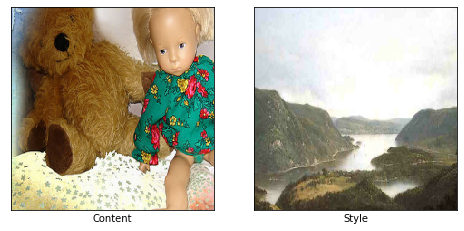

In [8]:
ds = build_dataset()
c_batch, s_batch = next(iter(ds.take(1)))

print('Content batch shape:', c_batch.shape)
print('Style batch shape:', s_batch.shape)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(np_image(c_batch[0]))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Content')

plt.subplot(1, 2, 2)
plt.imshow(np_image(s_batch[0]))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Style')

plt.show()

In [9]:
class AdaIN(tf.keras.layers.Layer):
    def __init__(self, name=None, epsilon=1e-8):
        super(AdaIN, self).__init__(name=name)
        self.epsilon = epsilon
        
    def call(self, Z):
        x, y = Z
        mu_x, var_x = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        mu_y, var_y = tf.nn.moments(y, axes=[1, 2], keepdims=True)
        sigma_x, sigma_y = tf.sqrt(var_x + self.epsilon), tf.sqrt(var_y + self.epsilon)
        return sigma_y * (x - mu_x) / sigma_x + mu_y

In [10]:
class ArbitraryStyleTransferNet(tf.keras.Model):
    CONTENT_LAYER = 'block4_conv1'
    STYLE_LAYERS = ('block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1')

    @staticmethod
    def declare_decoder():
        a_input = tf.keras.Input(shape=(28, 28, 512), name='input_adain')

        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(a_input)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(h)
        output = tf.keras.layers.Conv2DTranspose(3, 3, padding='same')(h)

        return tf.keras.Model(inputs=a_input, outputs=output, name='decoder')
  
    def __init__(self,
                 img_shape=(224, 224, 3),
                 content_loss_weight=1,
                 style_loss_weight=10,
                 name='arbitrary_style_transfer_net',
                 **kwargs):
        super(ArbitraryStyleTransferNet, self).__init__(name=name, **kwargs)

        self.img_shape = img_shape
        self.content_loss_weight = content_loss_weight
        self.style_loss_weight = style_loss_weight
        
        vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=img_shape)
        vgg19.trainable = False

        c_output = [vgg19.get_layer(ArbitraryStyleTransferNet.CONTENT_LAYER).output]
        s_outputs = [vgg19.get_layer(name).output for name in ArbitraryStyleTransferNet.STYLE_LAYERS]
        self.vgg19 = tf.keras.Model(inputs=vgg19.input, outputs=c_output+s_outputs, name='vgg19')
        self.vgg19.trainable = False

        self.adain = AdaIN(name='adain')
        self.decoder = ArbitraryStyleTransferNet.declare_decoder()
  
    def call(self, inputs):
        c_batch, s_batch = inputs

        c_enc = self.vgg19(c_batch)
        c_enc_c = c_enc[0]

        s_enc = self.vgg19(s_batch)
        s_enc_c = s_enc[0]
        s_enc_s = s_enc[1:] 
        
        # normalized_c is the output of AdaIN layer
        normalized_c = self.adain((c_enc_c, s_enc_c))
        output = self.decoder(normalized_c)

        # Calculate loss
        out_enc = self.vgg19(output)
        out_enc_c = out_enc[0]
        out_enc_s = out_enc[1:]

        loss_c = tf.reduce_mean(tf.math.squared_difference(out_enc_c, normalized_c))
        self.add_loss(self.content_loss_weight * loss_c)
        
        loss_s = 0
        for o, s in zip(out_enc_s, s_enc_s):    
            o_mean, o_var = tf.nn.moments(o, axes=(1,2), keepdims=True)
            o_std = tf.sqrt(o_var + self.adain.epsilon)

            s_mean, s_var = tf.nn.moments(s, axes=(1,2), keepdims=True)
            s_std = tf.sqrt(s_var + self.adain.epsilon)

            loss_mean = tf.reduce_mean(tf.math.squared_difference(o_mean, s_mean))
            loss_std = tf.reduce_mean(tf.math.squared_difference(o_std, s_std))

            loss_s += loss_mean + loss_std
        self.add_loss(self.style_loss_weight * loss_s)

        return output, c_enc_c, normalized_c, out_enc_c

In [11]:
ds = build_dataset()
model = ArbitraryStyleTransferNet(img_shape=IMG_SHAPE)

c_batch, s_batch = next(iter(ds.take(1)))
print(f'Input shape: ({c_batch.shape}, {s_batch.shape})')
output, *_ = model((c_batch, s_batch))
print(f'Output shape: {output.shape}')
print(f'Init. content loss: {model.losses[0]:,.2f}, style loss: {model.losses[1]:,.2f}')
model.summary()

Building dataset from 40,736 content images and 23,585 style images... done
Input shape: ((16, 224, 224, 3), (16, 224, 224, 3))
Output shape: (16, 224, 224, 3)
Init. content loss: 1,894,061.25, style loss: 12,323,039.00
Model: "arbitrary_style_transfer_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                [(None, 28, 28, 512), (No 3505728   
_________________________________________________________________
adain (AdaIN)                multiple                  0         
_________________________________________________________________
decoder (Model)              (None, 224, 224, 3)       3505219   
Total params: 7,010,947
Trainable params: 3,505,219
Non-trainable params: 3,505,728
_________________________________________________________________


In [12]:
# Train the model
optimizer = tf.keras.optimizers.Adam(lr=5e-4)
c_loss_metric, s_loss_metric = tf.keras.metrics.Mean(), tf.keras.metrics.Mean()

CKP_DIR = 'checkpoints'
init_epoch = 1

ckp = tf.train.latest_checkpoint(CKP_DIR)
if ckp:
    model.load_weights(ckp)
    init_epoch = int(ckp.split('_')[-1]) + 1
    print(f'Resume training from epoch {init_epoch-1}')

In [13]:
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        model(inputs)
        c_loss, s_loss = model.losses
        loss = c_loss + s_loss
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    c_loss_metric(c_loss)
    s_loss_metric(s_loss)

In [16]:
import os

def train(dataset, init_epoch):
    for epoch in range(init_epoch, EPOCHS+1):
        print(f'Epoch {epoch:>2}/{EPOCHS}')
        for step, inputs in enumerate(ds.take(STEPS_PER_EPOCH)):
            train_step(inputs)
            print(f'{step+1:>5}/{STEPS_PER_EPOCH} - loss: {c_loss_metric.result()+s_loss_metric.result():,.2f} - content loss: {c_loss_metric.result():,.2f} - style loss: {s_loss_metric.result():,.2f}', end='\r') 

        print()
        model.save_weights(os.path.join(CKP_DIR, f'ckpt_{epoch}'))
        c_loss_metric.reset_states()
        s_loss_metric.reset_states()

        output, c_enc_c, normalized_c, out_enc_c = model((c_batch, s_batch))
        plot_outputs((s_batch, c_batch, output, c_enc_c, normalized_c, out_enc_c), 
                     ('Style', 'Content', 'Trans', 'Content Enc', 'Normalized', 'Trans Enc'))

Epoch  1/30
  750/750 - loss: 845,729.75 - content loss: 372,701.00 - style loss: 473,028.75


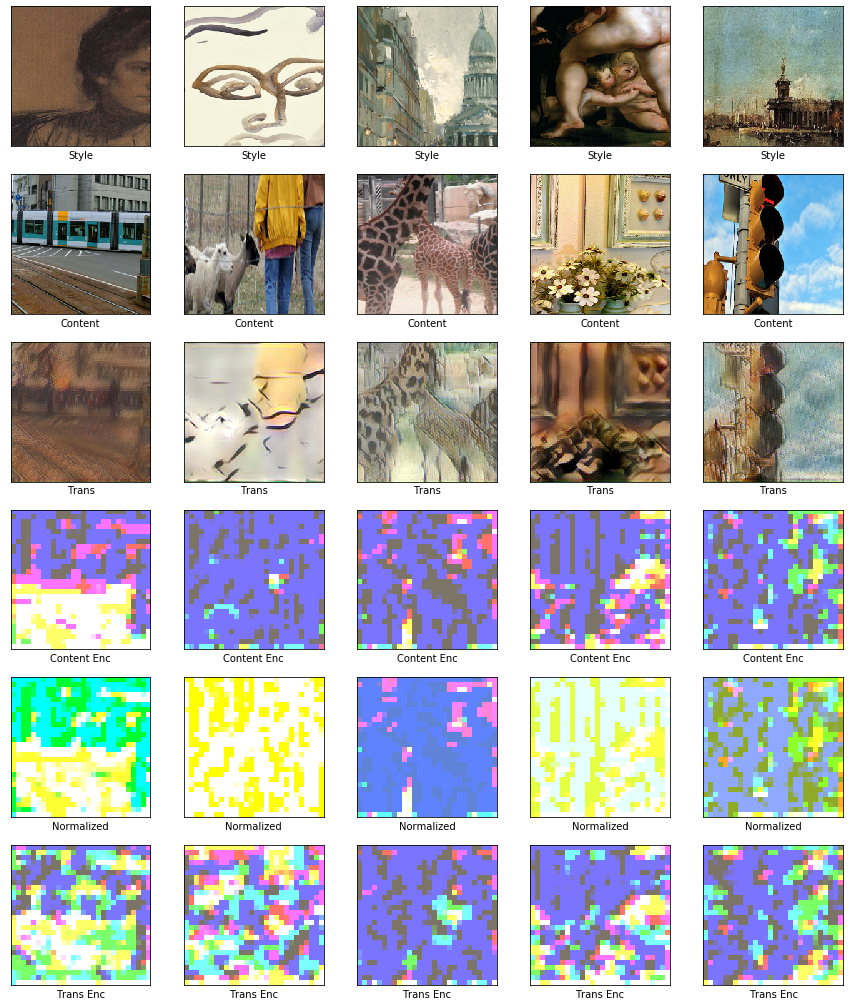

Epoch  2/30


KeyboardInterrupt: 

In [19]:
train(ds, init_epoch)